In [1]:
import os
import sys
import numpy as np
import networkx as nx
import itertools as it
import random as rd
import scipy.sparse as sp
import scipy.stats as st
import math
import community as community_louvain
import urllib.request
import gzip
import obonet
import colorsys
# from colormap import rgb2hex
# from colormap import hex2rgb
import pickle as pk
# from prettytable import PrettyTable
import os.path
import pandas as pd
from collections import defaultdict, Counter, ChainMap
import umap
import scipy.stats as st
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import fcluster
import time
# import statsmodels.sandbox.stats.multicomp as mc
from sklearn.preprocessing import normalize

import plotly.graph_objects as gp
from plotly.offline import init_notebook_mode, iplot
import json

import matplotlib.pyplot as plt
# %matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Library/Frameworks/Python.framework/V

## Functions

In [2]:

def eigenlayout(G, dim=3, n_lam=18, n_neighs=10, spread=1.0):
    """
    Compute the UMAP layout of a graph based on its normalized Laplacian matrix.

    Parameters:
    -----------
    G : NetworkX graph object
        The input graph.
    dim : int, optional (default=3)
        The number of dimensions in the UMAP projection.
    n_lam : int, optional (default=18)
        The number of eigenvalues and eigenvectors to use in the spectral dimensionality reduction.
    n_neighs : int, optional (default=10)
        The number of nearest neighbors to use in the UMAP algorithm.
    spread : float, optional (default=1.0)
        The spread of the UMAP projection.

    Returns:
    --------
    d_umap_pos : dictionary with graph nodes as keys and aray - shape: (n_nodes, dim) as values
        The UMAP projection of the graph nodes as a numpy array.
    """
    if n_lam > G.number_of_nodes()-1:
        print('The number of Eigenvectors must be smaller than the number of nodes - 1!')
        print('Please provide a smaller number. (Not more than 0.1xnumber_of_nodes recommended)')

    # Compute the normalized Laplacian matrix
    M_laplace = nx.normalized_laplacian_matrix(G, sorted(G.nodes()))

    # Construct the matrix M_ImL = I - L where L is the normalized Laplacian matrix and I is the identity matrix
    n_nodes = G.number_of_nodes()
    Id = sp.identity(n_nodes)
    M_ImL = Id - M_laplace

    # Compute the n_lam smallest eigenvalues and eigenvectors of M_ImL
    # M_V: #rows = #nodes and #cols = #eigenvls 
    Lam,M_V = sp.linalg.eigsh(M_ImL,k=n_lam)

    # FEATURE VECTOR
    # re-sort M_V by desc Lam - 1st column: eigenvec for largest Eigenvalue ...
    N = n_lam

    rev_ordered_idx = np.argsort(Lam)
    # spectral dimensional reduction:
    f_vec_1 = [x.real for x in M_V[:,rev_ordered_idx[-1]]]
    arr = f_vec_1

    for m in range(2,N+1):
        f_vec_2 = [x.real for x in M_V[:,rev_ordered_idx[-m]]]
        arr = np.vstack((arr,f_vec_2))

    # # UMAP
    FX = arr.transpose()

    mind = .2
    reducer = umap.UMAP(n_components=dim,n_neighbors=n_neighs, metric = 'cosine', min_dist=mind, spread = spread)
    umap_pos = reducer.fit_transform(FX)


    d_node_pos = {}

    for i, node in enumerate(sorted(G.nodes())):
        d_node_pos[node] = umap_pos[i,:]


    return d_node_pos




In [4]:


def download_mapping_file(url, filename):
    urllib.request.urlretrieve(url, filename)

def parse_mapping_file(filename):
    mapping = {}
    with gzip.open(filename, 'rt') as file:
        for line in file:
            if line.startswith('#'):  # Skip header and comments
                continue
            fields = line.strip().split('\t')
            if fields[0] == '9606':
                gene_symbol = fields[2]
                entrez_id = fields[1]
                ensembl_id = fields[5]
                # Additional mapping field
                gene_name = fields[11]
                if gene_symbol not in mapping:
                    mapping[gene_symbol] = {
                        'entrez_id': entrez_id,
                        'ensembl_id': ensembl_id,
                        'gene_name': gene_name
                    }
    return mapping


def convert_symbols_to_entrez(gene_symbols, mapping):
    entrez_ids = []
    for symbol in gene_symbols:
        if symbol in mapping:
            entrez_ids.append(mapping[symbol]['entrez_id'])
    return entrez_ids

def convert_symbols_to_ensembl(gene_symbols, mapping):
    ensembl_ids = []
    for symbol in gene_symbols:
        if symbol in mapping:
            ensembl_ids.append(mapping[symbol]['ensembl_id'])
    return ensembl_ids

# # Download Gene Info file (example using Homo sapiens)
url = 'ftp://ftp.ncbi.nlm.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz'
filename = 'Homo_sapiens.gene_info.gz'
download_mapping_file(url, filename)

# Parse mapping file
mapping = parse_mapping_file(filename)

# Generate a dictionary of all existing gene symbols and their corresponding Entrez IDs and Ensemble IDs
all_gene_symbols = list(mapping.keys())
all_entrez_ids = [mapping[symbol]['entrez_id'] for symbol in all_gene_symbols]
all_ensembl_ids = [mapping[symbol]['ensembl_id'] for symbol in all_gene_symbols]
symbol_to_entrez = dict(zip(all_gene_symbols, all_entrez_ids))
symbol_to_ensembl = dict(zip(all_gene_symbols, all_ensembl_ids))
entrez_to_symbols = {v: k for k, v in symbol_to_entrez.items()}
ensembl_to_symbols = {v: k for k, v in symbol_to_ensembl.items()}


### load PPI

In [5]:
def Ginfo(G):
    info = []
    info.append(f"Graph Name: {G.name}")
    info.append(f"Graph Type: {type(G).__name__}")
    info.append(f"Number of Nodes: {G.number_of_nodes()}")
    info.append(f"Number of Edges: {G.number_of_edges()}")
    info.append(f"Density: {round(100.*nx.density(G),3)} %")
    info.append(f"Average Degree: {round(sum(dict(G.degree()).values()) / G.number_of_nodes(),2)}")
    info.append(f"Connected: {'Yes' if nx.is_connected(G) else 'No'}")
    num_components = nx.number_connected_components(G)
    info.append(f"Number of Connected Components: {num_components}")
   
    info.append(f"Directed: {'Yes' if G.is_directed() else 'No'}")
    return "\n".join(info)
    return info

In [6]:

# PPI direct
path = 'data/'
G_ppi = nx.read_edgelist(path + 'PPI_physical_elist.csv',data=False, delimiter=',')
print(Ginfo(G_ppi))
print('\n')

lcc = max(nx.connected_components(G_ppi), key=len)
G = nx.subgraph(G_ppi,lcc)

print(Ginfo(G))

Graph Name: 
Graph Type: Graph
Number of Nodes: 18068
Number of Edges: 306914
Density: 0.188 %
Average Degree: 33.97
Connected: No
Number of Connected Components: 2
Directed: No


Graph Name: 
Graph Type: Graph
Number of Nodes: 18064
Number of Edges: 306911
Density: 0.188 %
Average Degree: 33.98
Connected: Yes
Number of Connected Components: 1
Directed: No


### spectral decomposition

of the symmetric Laplacian 
(takes like 20 mins)

you can make a test run with a smaller sample (see optional next cell)


In [11]:

n = 5000  # Number of nodes to sample

# Step 1: Randomly sample n nodes from the graph
sampled_nodes = rd.sample(list(G.nodes()), n)

# Step 2: Create a subgraph with the sampled nodes
sampled_subgraph = G.subgraph(sampled_nodes)

# Step 3: Extract the largest connected component (LCC)
lcc = max(nx.connected_components(sampled_subgraph), key=len)
G_lcc_sample = G.subgraph(lcc)

print(Ginfo(G_lcc_sample))

Graph Name: 
Graph Type: Graph
Number of Nodes: 4412
Number of Edges: 23531
Density: 0.242 %
Average Degree: 10.67
Connected: Yes
Number of Connected Components: 1
Directed: No


In [12]:

# Compute the normalized Laplacian matrix
M_laplace = nx.normalized_laplacian_matrix(G_lcc_sample, sorted(G_lcc_sample.nodes()))

n_nodes = G_lcc_sample.number_of_nodes()

# Compute the n_lam largest eigenvalues and eigenvectors of M_Laplace
Lam, M_V = sp.linalg.eigsh(M_laplace, k=n_nodes-1, which='LM')

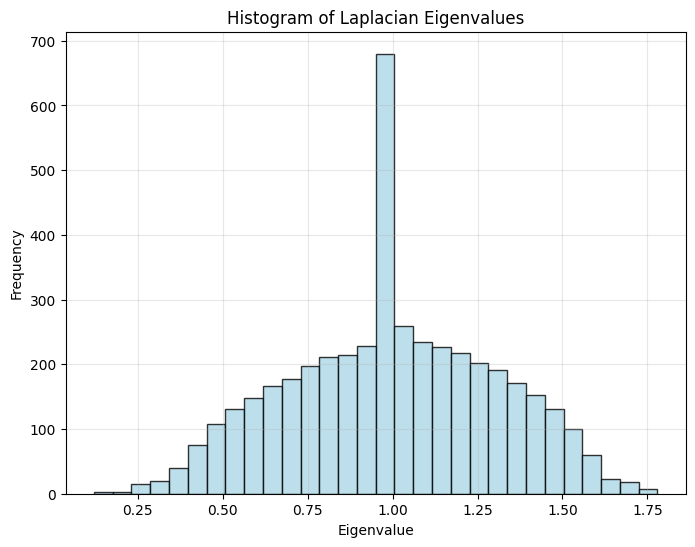

In [23]:

# Plot the eigenvalues as a histogram
plt.figure(figsize=(8, 6))
plt.hist(Lam, bins=30, color='lightblue', edgecolor='black', alpha=0.8)
plt.title("Histogram of Laplacian Eigenvalues")
plt.xlabel("Eigenvalue")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()

In [20]:
# APPLY SPECTRALLY DECOMPOSED EIGENVECTORS FOR LAYOUT

d_pos_eigen = eigenlayout(G_lcc_sample, dim=2, n_lam=30, n_neighs=10, spread=5.0)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/umap/umap_.py:1356: RuntimeWarning:

divide by zero encountered in power



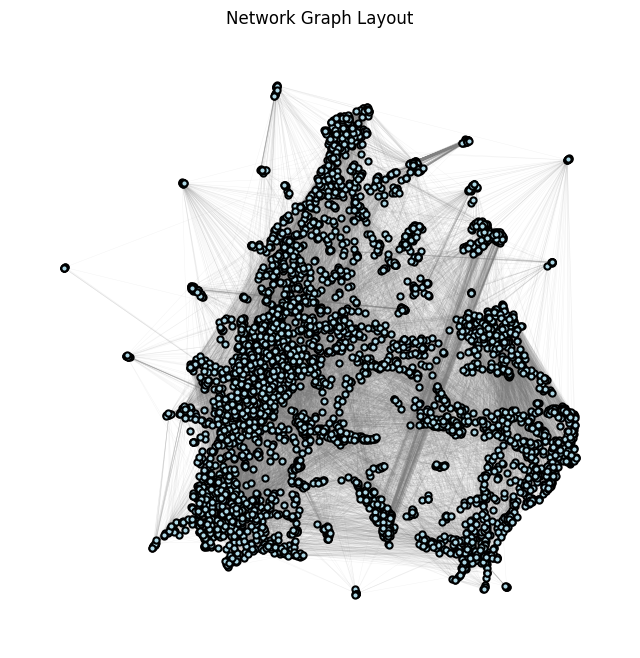

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx


# Step 1: Extract node positions
x_coords = [d_pos_eigen[node][0] for node in G_lcc_sample.nodes()]
y_coords = [d_pos_eigen[node][1] for node in G_lcc_sample.nodes()]

# Step 2: Create a scatter plot for the nodes
plt.figure(figsize=(8, 8))

# Draw edges first so they appear behind the nodes
nx.draw_networkx_edges(G_lcc_sample, pos=d_pos_eigen, edge_color='gray', alpha=0.1,width=.3)

# Draw nodes with a black border and light blue inner color
plt.scatter(
    x_coords, y_coords,
    s=20,  # Node size
    c='lightblue',  # Inner face color
    edgecolors='black',  # Border color
    linewidths=1.5,  # Border thickness
    alpha=1,  # Node transparency
    zorder=3  # Ensure nodes are drawn on top of edges
)

# Step 3: Add labels and show the plot
plt.title("Eigenmap")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.axis("off")  # Turn off the axis for a cleaner look
plt.show()